## Name: vorticity_autocorr_comparison.ipynb

Author: Robby M. Frost

University of Oklahoma

Created: 19 September 2024

Purpose: Compare plot of vertical vorticity to the 2D autocorrelation of vertical vorticity

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import gzip
import os
from functions import *
import matplotlib.pyplot as plt
from matplotlib import rc
import pyart
from matplotlib.ticker import MultipleLocator
import xrft

Read in lidar file

In [54]:
# date/time info of lidar scans
des_year = "2023"
des_mon = "10"
des_day = "07"
des_file = "20231007233739_PPI_1.nc.gz"
des_sys = "WG100-L0AD00004JP"
lidar_loc = "Hampton, VA" # Hampton, VA or Oklahoma Mobile
# directory storing 24 hours of lidar data
directory = f"/data/arrcwx/robbyfrost/lidar_obs/{des_sys}/{des_year}/{des_mon}/{des_day}/"
# directory for saving figues
figdir = f"/home/robbyfrost/analysis/TurbTor_Lidar/figures/{des_sys}/{des_year}/{des_mon}/{des_day}/"
os.makedirs(figdir, exist_ok=True)

dfile = directory + des_file
with gzip.open(dfile, 'rb') as f:
    ds = xr.open_dataset(f)

    # check scan is good
    if (ds.ntime.size > 100) and (ds.nrange.size > 100):
        # account for range offset
        range_offset = 1425 # meters
        start_point = np.argmin(abs(ds.ranges.data-range_offset))+1
        # scan dimensions
        r = ds.ranges[start_point:].data - range_offset
        az = ds.azimuth.data
        el = ds.elevation.data
        # radial velocity
        vr = ds.dpl[:,0,start_point:].data
        # calculate vertical vorticity
        vort_z = ( (vr[1:,:] - vr[:-1,:]) / (np.deg2rad(az[1:]) - np.deg2rad(az[:-1]))[:,np.newaxis] ) * (1 / r)
        # other observations
        pwr = ds.pwr[:,0,start_point:].data * 100
        snr = ds.snr[:,0,start_point:].data
        sw = ds.wth[:,0,start_point:].data
        noise_level = ds.noise_level[:,0,start_point:].data
        # power_spectra = ds.power_spectra[:,0,start_point:].data
        doppler_velocity = ds.doppler_velocity.data
        # lidar information
        ob_method = ds.attrs['observation_method']
        serial_number = ds.attrs['serial_number']
        lat = ds.latitude.data
        lon = ds.longitude.data
        altitude = ds.altitude.data
        # scan setting information
        rpm_azimuth = ds.rpm_azimuth[start_point:].data
        # scan time information
        record_start_time = ds.start_time.data
        start_time = ds.attrs['start_time'][11:19]
        start_date = ds.attrs['start_time'][:10]
        end_time = ds.attrs['end_time'][11:19]
        end_date = ds.attrs['end_time'][:10]

Calculate 2D autocorrelation

In [55]:
# grab data
vort = xr.DataArray(vort_z, dims=("az","r"), coords={'az': az[:-1], 'r': r}).fillna(0)
# Create uniform coordinates for azimuth and range
az_uniform = np.linspace(vort.az.min().data, vort.az.max().data, vort.shape[0])
r_uniform = np.linspace(vort.r.min().data, vort.r.max().data, vort.shape[1])
# Interpolate data onto uniform grid
vort_uniform = vort.interp(az=az_uniform, r=r_uniform)
# subtract x,y mean
dfluc = xrft.detrend(vort_uniform, dim=("az","r"), detrend_type="constant")
# normalize by standard deviation
dnorm = dfluc / dfluc.std(dim=("az","r"))
# calculate PSD using xrft
PSD = xrft.power_spectrum(dnorm, dim=("az","r"), true_phase=True, 
                            true_amplitude=True)
# take real part of ifft to return ACF
R = xrft.ifft(PSD, dim=("freq_az","freq_r"), true_phase=True, 
                true_amplitude=True, lag=(0,0)).real
# remove negative radial lags
R = R.where(R.r >= 0, drop=True)

Plotting set up

In [56]:
# Set the font weight for plot titles
# plt.rcParams['axes.titleweight'] = 'bold'
# Set the font weight for x-axis and y-axis labels
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

# Other plotting setup
rc('font', family='sans-serif')
rc('font', weight='normal', size=15)
rc('figure', facecolor='white')

In [57]:
XX, YY = dis_angle_to_2Dxy(r,az)

/tmp/ipykernel_738135/2253757166.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm1 = ax[0].pcolormesh(XX.T[:-1]/1e3, YY.T[:-1]/1e3, vort_z,


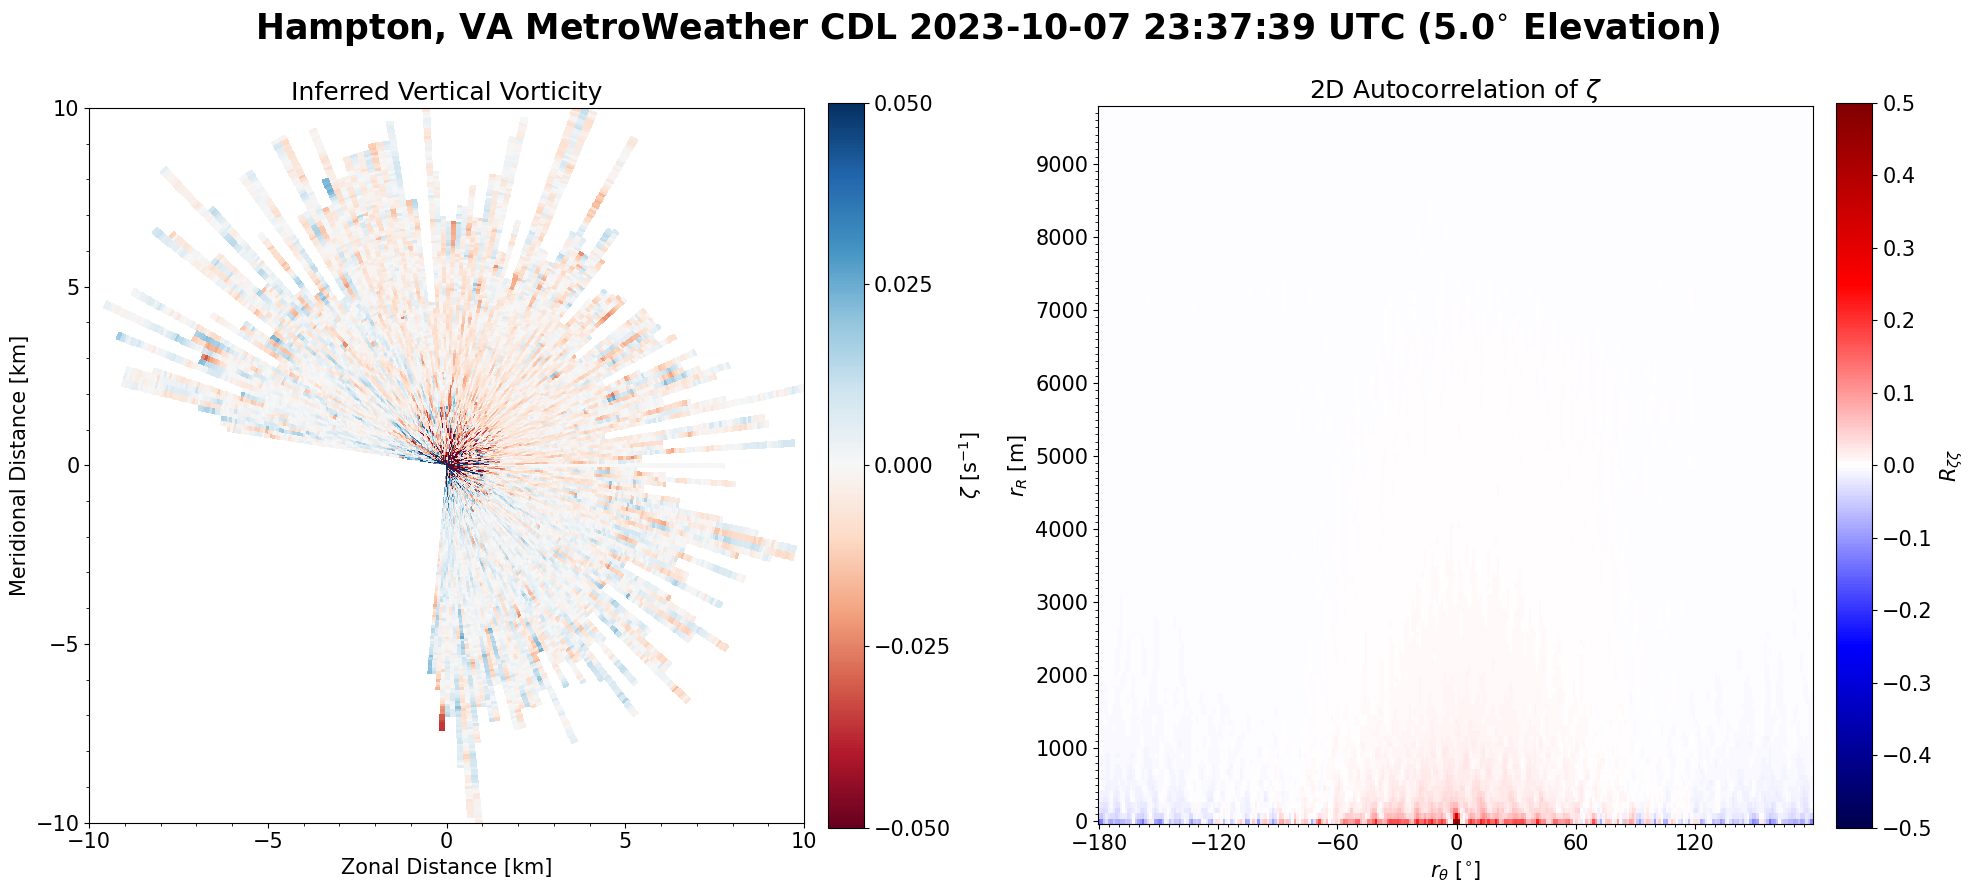

In [85]:
rmax = 10 # km

fig, ax = plt.subplots(figsize=(20,10), ncols=2)

vmin, vmax = -0.05, 0.05
pcm1 = ax[0].pcolormesh(XX.T[:-1]/1e3, YY.T[:-1]/1e3, vort_z,
                        vmin=vmin, vmax=vmax,
                        cmap="RdBu")
ax[0].set_title("Inferred Vertical Vorticity")
cbar2 = fig.colorbar(pcm1, ax=ax[0], aspect=20, pad=0.03, fraction=0.06, shrink=0.81)
cbar2.set_label("$\\zeta$ [s$^{-1}$]")
cbar2.set_ticks(np.arange(vmin, vmax+0.0001, 0.025))
ax[0].set_xlim(-rmax,rmax)
ax[0].set_ylim(-rmax,rmax)
ax[0].set_aspect('equal')
ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_minor_locator(MultipleLocator(1))
ax[0].set_xlabel("Zonal Distance [km]")
ax[0].yaxis.set_major_locator(MultipleLocator(5))
ax[0].yaxis.set_minor_locator(MultipleLocator(1))
ax[0].set_ylabel("Meridional Distance [km]")

vmin, vmax = -0.5, 0.5
pcm2 = ax[1].pcolormesh(R.az, R.r, R.T, 
                        vmin=vmin, vmax=vmax, 
                        cmap="seismic")
ax[1].set_title("2D Autocorrelation of $\\zeta$")
cbar1 = fig.colorbar(pcm2, ax=ax[1], aspect=20, pad=0.03, fraction=0.06, shrink=0.81)
cbar1.set_label("$R_{\\zeta \\zeta}$")
cbar1.set_ticks(np.arange(vmin, vmax+0.001, 0.1))
aspect_ratio = (R.az.max() - R.az.min()) / (R.r.max() - R.r.min())
ax[1].set_aspect(aspect_ratio)  # Set the calculated aspect ratio
ax[1].xaxis.set_major_locator(MultipleLocator(60))
ax[1].xaxis.set_minor_locator(MultipleLocator(5))
ax[1].set_xlabel("$r_{\\theta}$ [$^{\\circ}$]")
ax[1].yaxis.set_major_locator(MultipleLocator(1000))
ax[1].yaxis.set_minor_locator(MultipleLocator(100))
ax[1].set_ylabel("$r_R$ [m]")

plt.suptitle(f"{lidar_loc} MetroWeather CDL {start_date} {start_time} UTC ({round(el[0],1)}$^{{\\circ}}$ Elevation)", 
             fontweight="bold", fontsize=25, y=0.925)

fig.tight_layout()